In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.integrate import cumulative_trapezoid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler,MinMaxScaler

2025-05-18 10:47:11.700797: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 10:47:11.711543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747550831.725775   26723 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747550831.729332   26723 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747550831.740130   26723 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
bat_dict = pickle.load(open(r'./Data/bat_dict.pkl', 'rb'))

In [4]:
print(bat_dict.keys())
print(bat_dict["b1c0"].keys())
print(bat_dict["b1c0"]["summary"].keys())
print(bat_dict["b1c0"]["cycles"].keys())
print(bat_dict["b1c0"]["cycles"]["10"].keys())

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47'])
dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])
dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17'

In [5]:
b1 = []
b2 = []

for bat in bat_dict.keys():
    if bat_dict[bat]["summary"]["QD"][0] < 0.9:
        b1.append(bat)
    
    for i in range(1, len(bat_dict[bat]["summary"]["QD"])):
        if bat_dict[bat]["summary"]["QD"][i] > 1.1:
            b2.append(bat)

print(b1)
print(b2)

['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45']
['b1c0', 'b1c18', 'b2c12', 'b2c44']


In [6]:
max_cycle = -np.inf
min_cycle = np.inf

for bat in bat_dict.keys():
    if bat_dict[bat]["cycle_life"] > max_cycle:
        max_cycle = bat_dict[bat]["cycle_life"][0][0]
    
    if bat_dict[bat]["cycle_life"] < min_cycle:
        min_cycle = bat_dict[bat]["cycle_life"][0][0]

print(max_cycle, min_cycle)

2237.0 148.0


In [7]:
for bat in bat_dict.keys():
    if bat in b1:
        for key in bat_dict[bat]["summary"].keys():
            bat_dict[bat]["summary"][key] = bat_dict[bat]["summary"][key][1:]

In [8]:
q_nominal = 1.1
volt_min = 2.0
volt_max = 3.5
num_volt_points = 1000
common_volt_grid = np.linspace(volt_min, volt_max, num_volt_points)
num_early_cycles = 100
seq_len = 100

In [9]:
def get_Q_V_curve_from_VIT(battery_id, cycle_num_str, bat_dict_local):
        cycle_data = bat_dict_local[battery_id]['cycles'][cycle_num_str]

        V_raw = np.array(cycle_data['V'])
        I_raw = np.array(cycle_data['I'])
        t_raw = np.array(cycle_data['t'])

        discharge_indices = np.where(I_raw < -0.01)[0]
        
        if len(discharge_indices) < 2:
            discharge_indices = np.where(I_raw > 0.01)[0]

        V_discharge = V_raw[discharge_indices]
        I_discharge = I_raw[discharge_indices]
        t_discharge = t_raw[discharge_indices]

            
        # Calculate dQ: current is in Amps, time in seconds. Q will be in Amp-seconds (Coulombs).
        # Convert to Amp-hours by dividing by 3600.
        # abs(I_discharge) because we want magnitude for capacity.
        # cumtrapz calculates cumulative integral of y (abs(I_discharge)) w.r.t x (t_discharge)
        Q_cumulative_Ah = cumulative_trapezoid(np.abs(I_discharge), t_discharge, initial=0) / 3600.0
        
        # sort by V_discharge descending for interpolation
        sort_indices = np.argsort(V_discharge)[::-1]
        V_sorted_desc = V_discharge[sort_indices]
        Q_sorted_desc = Q_cumulative_Ah[sort_indices]
        
        # for np.interp, xp (V_for_interp) must be increasing
        V_for_interp = V_sorted_desc[::-1]
        Q_for_interp = Q_sorted_desc[::-1]
        
        unique_V_indices = np.unique(V_for_interp, return_index=True)[1]
        V_unique_for_interp = V_for_interp[unique_V_indices]
        Q_unique_for_interp = Q_for_interp[unique_V_indices]
            
        # interpolate onto the common_voltage_grid
        # common_voltage_grid is MAX to MIN, so common_voltage_grid[::-1] is MIN to MAX
        Q_interpolated_asc = np.interp(common_volt_grid[::-1], V_unique_for_interp, Q_unique_for_interp)
        
        # return in the order of the original common_voltage_grid (max to min)
        return Q_interpolated_asc[::-1]

In [10]:
def extract_early_life_features(battery_id, bat_dict_local, n_early_cycles=num_early_cycles):
    features = {}
    Q10 = get_Q_V_curve_from_VIT(battery_id, '10', bat_dict_local)
    Q100 = get_Q_V_curve_from_VIT(battery_id, '100', bat_dict_local)
    features['var_delta_Q_100_10'] = np.var(Q100 - Q10)
    
    summary = bat_dict_local[battery_id].get('summary', {})
    
    summary_cycles = np.array(summary['cycle'])
    early_indices = np.where(summary_cycles <= n_early_cycles)[0]
    if len(early_indices) < 2: return None
    
    def get_early_summary_metric(key_name):
        if key_name in summary:
            data_array = np.array(summary[key_name])[early_indices]
            if len(data_array) > 0: return data_array
        return np.array([])

    ir_early = get_early_summary_metric('IR')
    features['IR_mean_early'] = np.mean(ir_early) if len(ir_early) > 0 else np.nan
    chargetime_early = get_early_summary_metric('chargetime')
    features['chargetime_mean_early'] = np.mean(chargetime_early) if len(chargetime_early) > 0 else np.nan
    tavg_early = get_early_summary_metric('Tavg')
    features['Tavg_mean_early'] = np.mean(tavg_early) if len(tavg_early) > 0 else np.nan
    qd_early = get_early_summary_metric('QD')
    cycles_for_qd_early = summary_cycles[early_indices]

    #if len(qd_early) >= 2 and len(cycles_for_qd_early) == len(qd_early):
    #    slope, intercept, r_value, p_value, std_err = linregress(cycles_for_qd_early, qd_early)
    #    features['QD_slope_early'] = slope
    #    features['QD_var_early'] = np.var(qd_early)
    #else:
    #    features['QD_slope_early'] = np.nan
    #    features['QD_var_early'] = np.nan
    
    if any(np.isnan(val) for key, val in features.items() if key != 'var_delta_Q_100_10'): 
         if np.isnan(features.get('IR_mean_early', np.nan)) or \
            np.isnan(features.get('chargetime_mean_early', np.nan)) or \
            np.isnan(features.get('Tavg_mean_early', np.nan)):
            #np.isnan(features.get('QD_slope_early', np.nan)) or \
            #np.isnan(features.get('QD_var_early', np.nan)):
            return None
            
    return features

In [11]:
all_batteries_data_for_lstm = []
    
static_feature_names = ['var_delta_Q_100_10', 'IR_mean_early', 'chargetime_mean_early', 'Tavg_mean_early']
dynamic_feature_names = ['SOH', "delta_SOH", 'cycle_norm']

for battery_id in list(bat_dict.keys()):
    early_features = extract_early_life_features(battery_id, bat_dict)
    if early_features is None:
        print(f"Skipping {battery_id}: couldn't extract early life features")
        continue

    summary = bat_dict[battery_id].get('summary', {})

    battery_df = pd.DataFrame({
        'cycle': summary['cycle'],
        'SOH': (np.array(summary['QD']) /q_nominal) * 100
    })
    battery_df = battery_df.sort_values(by='cycle').reset_index(drop=True)

    if len(battery_df) < seq_len + 1:
        print(f"skipping {battery_id}: not enough data ({len(battery_df)}) for sequence length")
        continue

    static_features_values = [early_features[name] for name in static_feature_names]
    all_batteries_data_for_lstm.append({
        'id': battery_id,
        'static_features': np.array(static_features_values),
        'dynamic_df': battery_df 
    })

In [12]:
train_batteries_data, test_batteries_data = train_test_split(all_batteries_data_for_lstm, test_size=0.25, random_state=987123)

In [13]:
static_features_train_list = [b['static_features'] for b in train_batteries_data]
static_scaler = StandardScaler()
static_scaler.fit(np.array(static_features_train_list))

all_train_soh = np.concatenate([b['dynamic_df']['SOH'].values for b in train_batteries_data]).reshape(-1, 1)
soh_scaler = MinMaxScaler(feature_range=(0, 1))
soh_scaler.fit(all_train_soh)

all_train_delta_soh_list = []
for b_data in train_batteries_data:
    delta_soh_unscaled = b_data['dynamic_df']['SOH'].diff().fillna(0).values # fillna(0) for first item
    all_train_delta_soh_list.append(delta_soh_unscaled)
all_train_delta_soh = np.concatenate(all_train_delta_soh_list).reshape(-1, 1)

delta_soh_scaler = MinMaxScaler(feature_range=(-1, 1))
delta_soh_scaler.fit(all_train_delta_soh)

all_train_cycles = np.concatenate([b['dynamic_df']['cycle'].values for b in train_batteries_data]).reshape(-1, 1)
cycle_scaler = MinMaxScaler(feature_range=(0, 1))
cycle_scaler.fit(all_train_cycles)

MinMaxScaler()

In [14]:
def create_lstm_sequences(batteries_data, static_scaler, soh_scaler, cycle_scaler, sequence_length):
    X_seq, y_seq = [], []
    num_static_feats = len(static_feature_names)
    # num_dynamic_feats = 3 (SOH_scaled, delta_soh_scaled, cycle_scaled)
        
    for battery_data in batteries_data:
        static_feats_scaled = static_scaler.transform(battery_data['static_features'].reshape(1, -1))[0]

        df = battery_data['dynamic_df'].copy()
        df['SOH_scaled'] = soh_scaler.transform(df[['SOH']])
        df['delta_SOH_unscaled'] = df['SOH'].diff().fillna(0)
        df['delta_SOH_scaled'] = delta_soh_scaler.transform(df[['delta_SOH_unscaled']])
        df['cycle_scaled'] = cycle_scaler.transform(df[['cycle']])

        for i in range(len(df) - sequence_length):
            dynamic_part = df[['SOH_scaled', 'delta_SOH_scaled', 'cycle_scaled']].iloc[i : i + sequence_length].values

            # tile static feats to match sequence length and then concat
            static_part_tiled = np.tile(static_feats_scaled, (sequence_length, 1))

            sequence = np.concatenate((dynamic_part, static_part_tiled), axis=1)
            X_seq.append(sequence)
            y_seq.append(df['SOH_scaled'].iloc[i + sequence_length]) # target is next SOH_scaled

    return np.array(X_seq), np.array(y_seq)

In [15]:
X_train, y_train = create_lstm_sequences(train_batteries_data, static_scaler, soh_scaler, cycle_scaler, seq_len)
X_test, y_test = create_lstm_sequences(test_batteries_data, static_scaler, soh_scaler, cycle_scaler, seq_len)

print(f"Training sequences: X_train shape {X_train.shape}, y_train shape {y_train.shape}")

/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/

Training sequences: X_train shape (37883, 100, 7), y_train shape (37883,)


/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [16]:
# num_features_per_step = SOH_scaled + delta_SOH_scaled +cycle_scaled + num_static_features
num_dynamic_in_seq = 3
num_features_per_step = num_dynamic_in_seq + len(static_feature_names)

model = Sequential([
    Input(shape=(seq_len, num_features_per_step)),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='tanh')),
    Dropout(0.3),
    Dense(16, activation='tanh'),
    Dropout(0.3),
    Dense(1) #predicts next SOH_scaled
])

optimizer = Adam(learning_rate=0.00002)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

I0000 00:00:1747550851.439716   26723 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1401 MB memory:  -> device: 0, name: NVIDIA GeForce MX550, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100, 64)        │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,369 (306.13 KB)

 Trainable params: 78,369 (306.13 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
history = None

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/100


I0000 00:00:1747550854.778841   26788 cuda_dnn.cc:529] Loaded cuDNN version 90701


592/592 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.0444 - val_loss: 9.2926e-04
Epoch 2/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0135 - val_loss: 6.3321e-04
Epoch 3/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 0.0092 - val_loss: 5.4162e-04
Epoch 4/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0069 - val_loss: 5.4085e-04
Epoch 5/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0053 - val_loss: 5.7417e-04
Epoch 6/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0042 - val_loss: 4.4775e-04
Epoch 7/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0035 - val_loss: 3.9269e-04
Epoch 8/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 0.0029 - val_loss: 3.8061e-04
Epoch 9/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0024 - val_loss: 3.5417e-04
Epoch 10/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0021 - val_loss: 3.4579e-04
Epoch 11/100
592/592 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0018 - val_loss

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
LSTM Test Set Performance (on one-step ahead predictions):
  R^2 Score: 0.9113
  MAE: 0.9572 (SOH %)
  RMSE: 1.5523 (SOH %)


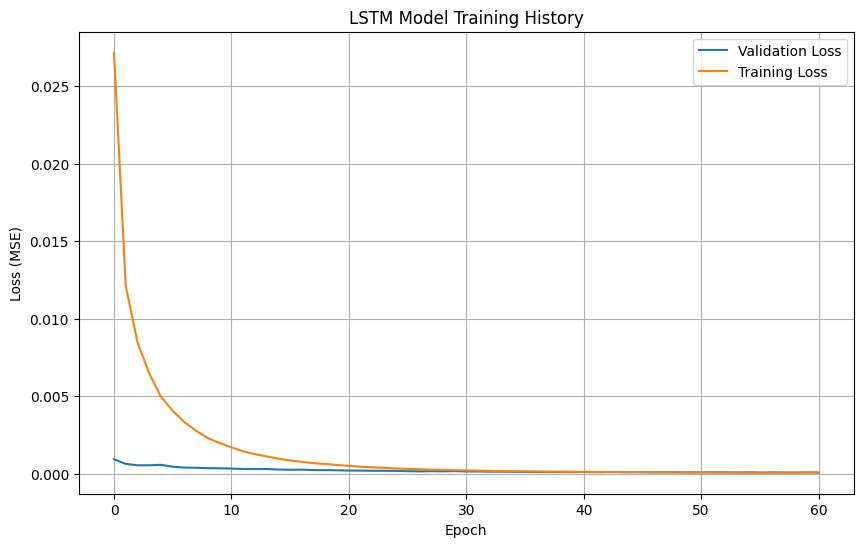

In [ ]:
y_pred_scaled_test = model.predict(X_test)
y_pred_test = soh_scaler.inverse_transform(y_pred_scaled_test)
y_actual_test = soh_scaler.inverse_transform(y_test.reshape(-1,1))

r2_lstm = r2_score(y_actual_test, y_pred_test)
mae_lstm = mean_absolute_error(y_actual_test, y_pred_test)
rmse_lstm = np.sqrt(mean_squared_error(y_actual_test, y_pred_test))
print(f"LSTM Test Set Performance (on one-step ahead predictions):")
print(f"R^2 Score: {r2_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f} (SOH %)")
print(f"RMSE: {rmse_lstm:.4f} (SOH %)")

plt.figure(figsize=(10,6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
battery_to_plot_data = test_batteries_data[0] 
n_known_cycles = 300
print(f"\nGenerating SOH curve prediction for test battery: {battery_to_plot_data['id']} from cycle {n_known_cycles+1}")

df_plot = battery_to_plot_data['dynamic_df'].copy()
static_feats_plot_scaled = static_scaler.transform(battery_to_plot_data['static_features'].reshape(1, -1))[0]
        
# scale the dynamic features for entire history of this battery
df_plot['SOH_scaled'] = soh_scaler.transform(df_plot[['SOH']])
df_plot['delta_SOH_unscaled'] = df_plot['SOH'].diff().fillna(0)
df_plot['delta_SOH_scaled'] = delta_soh_scaler.transform(df_plot[['delta_SOH_unscaled']])
df_plot['cycle_scaled'] = cycle_scaler.transform(df_plot[['cycle']])

actual_soh_full = df_plot['SOH'].values
actual_cycles_full = df_plot['cycle'].values
        
# find the index corresponding to n_known_cycles
known_data_end_index = df_plot[df_plot['cycle'] <= n_known_cycles].index.max()

if known_data_end_index is None or known_data_end_index < seq_len-1 :
    print(f"Battery {battery_to_plot_data['id']} doesn't have enough data up to {n_known_cycles} to form a sequence of length {seq_len}")
else:
    start_idx_for_seed = known_data_end_index - seq_len+1
    end_idx_for_seed = known_data_end_index + 1
    initial_sequence_dynamic_part = df_plot[['SOH_scaled', 'delta_SOH_scaled', 'cycle_scaled']].iloc[start_idx_for_seed : end_idx_for_seed].values
    
    current_static_part_tiled = np.tile(static_feats_plot_scaled, (seq_len, 1))
    current_input_sequence = np.concatenate((initial_sequence_dynamic_part, current_static_part_tiled), axis=1).reshape(1, seq_len, num_features_per_step)
    predicted_soh_scaled_iterative = []
    
    # we predict for the remaining cycles for which we have actual data in this battery for comparison
    num_prediction_steps = len(df_plot) - (known_data_end_index + 1)

    last_known_soh_scaled = initial_sequence_dynamic_part[-1,0]
        
    for i in range(num_prediction_steps):
        next_soh_scaled_pred = model.predict(current_input_sequence, verbose=0)[0,0]
        predicted_soh_scaled_iterative.append(next_soh_scaled_pred)

        prev_soh_unscaled = soh_scaler.inverse_transform([[last_known_soh_scaled]])[0,0]
        current_pred_soh_unscaled = soh_scaler.inverse_transform([[next_soh_scaled_pred]])[0,0]
        next_delta_soh_unscaled = current_pred_soh_unscaled - prev_soh_unscaled
        next_delta_soh_scaled = delta_soh_scaler.transform([[next_delta_soh_unscaled]])[0,0]
        
        last_known_soh_scaled = next_soh_scaled_pred

        #idx for the cycle for which we just predicted soh
        target_cycle_index_in_df = known_data_end_index + 1 + i 
            
        next_cycle_scaled = df_plot['cycle_scaled'].iloc[target_cycle_index_in_df]
        
        new_dynamic_row = np.array([[next_soh_scaled_pred, next_delta_soh_scaled, next_cycle_scaled]])        
        
        # update dynamic part of sequence for the next prediction
        updated_dynamic_part = np.append(current_input_sequence[0, 1:, :num_dynamic_in_seq], new_dynamic_row, axis=0)                                
        
        current_input_sequence = np.concatenate((updated_dynamic_part, current_static_part_tiled), axis=1).reshape(1, seq_len, num_features_per_step)
    
    predicted_soh_iterative = soh_scaler.inverse_transform(np.array(predicted_soh_scaled_iterative).reshape(-1,1)).flatten()


Generating SOH curve prediction for test battery: b1c7 from cycle 301


/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/javid/Documents/UFAZ/Data Mining/project/bat_pred/venv/lib64/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


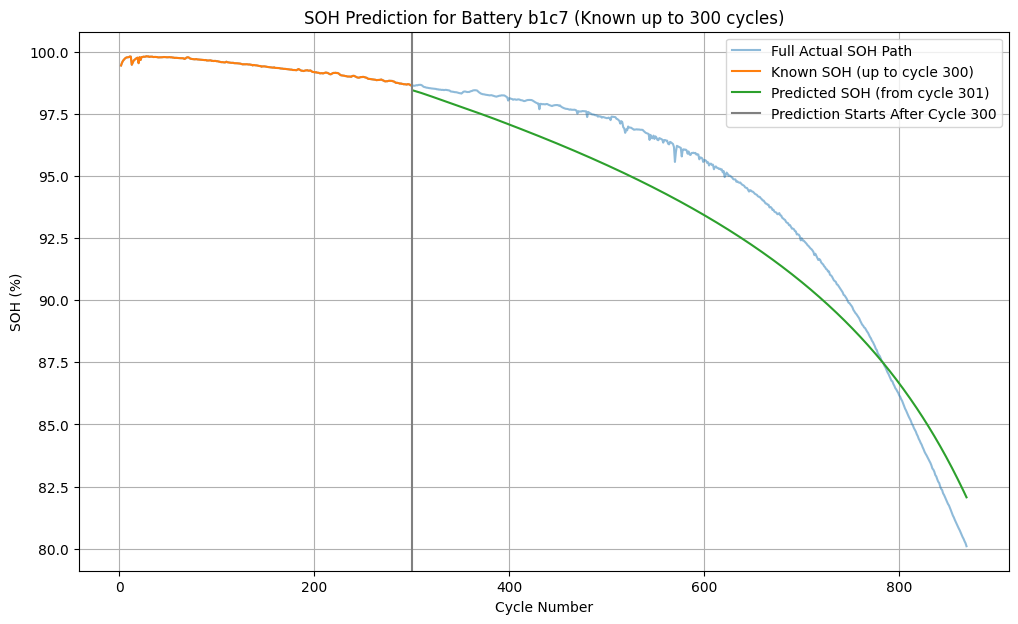

In [20]:
plt.figure(figsize=(12,7))
plt.plot(actual_cycles_full, actual_soh_full, label='Full Actual SOH Path', markersize=2, alpha=0.5)

known_cycles = actual_cycles_full[:known_data_end_index+1]
known_soh = actual_soh_full[:known_data_end_index+1]
plt.plot(known_cycles, known_soh, label=f'Known SOH (up to cycle {int(known_cycles[-1]) if len(known_cycles)>0 else n_known_cycles})', markersize=3)


predicted_cycles = actual_cycles_full[known_data_end_index+1 : known_data_end_index+1+len(predicted_soh_iterative)]
if len(predicted_cycles) == len(predicted_soh_iterative) and len(predicted_cycles) > 0:
    plt.plot(predicted_cycles, predicted_soh_iterative, label=f'Predicted SOH (from cycle {int(predicted_cycles[0])})', markersize=3)
else:
    print("Warning: Mismatch in length of predicted cycles and SOH values, or no predictions to plot.")
plt.title(f'SOH Prediction for Battery {battery_to_plot_data["id"]} (Known up to {n_known_cycles} cycles)')
plt.xlabel('Cycle Number')
plt.ylabel('SOH (%)')
plt.axvline(x=n_known_cycles, color='gray', label=f'Prediction Starts After Cycle {n_known_cycles}')
plt.legend()
plt.grid(True)
plt.show()